<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/Anjan/Session%207%20-%20Advanced%20Convolutions/S7_rough_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

transform = transforms.Compose(
    [transforms.RandomRotation((-12.0, 12.0)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

transform1 = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=4,pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   cat   dog plane


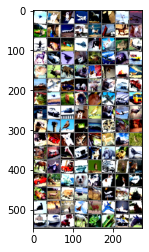

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.Layer1 = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=2, bias=False),  # output_size = 34  RF : 3
            nn.ReLU(),
            nn.BatchNorm2d(32), 

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2, bias=False), # output_size = 36  RF : 5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=64, padding=1,bias=False),   # output_size = 36  RF : 7
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1,bias=False),   # output_size = 36  RF : 7
            nn.ReLU(),
            nn.BatchNorm2d(128),

              # Dilated convolution
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, dilation=2,bias=False),  # output_size = 36  RF : 11
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,bias=False),  # output_size = 36  RF : 13
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, padding=0, bias=False),   # output_size = 36  RF : 13
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # # output_size = 18  RF : 14
           
        )
      
      self.Layer2 = nn.Sequential(
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, bias=False), # output_size = 20  RF : 18
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=64, padding=1,bias=False),   # output_size = 20  RF : 22
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1,bias=False),   # output_size = 20  RF : 22
            nn.ReLU(),
            nn.BatchNorm2d(128),

              # Dilated convolution
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, dilation=2,bias=False),  # output_size = 20  RF : 30
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,bias=False),  # output_size = 20  RF : 34
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),   # output_size = 20  RF : 34

            nn.MaxPool2d(2, 2)  # # output_size = 10  RF : 35
           
        )
      
      self.Layer3 = nn.Sequential(
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, bias=False), # output_size = 12  RF : 43
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=64, padding=1,bias=False),   # output_size = 12  RF : 51
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1,bias=False),   # output_size = 12  RF : 51
            nn.ReLU(),
            nn.BatchNorm2d(128),

              # Dilated convolution
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, dilation=2,bias=False),  # output_size = 12  RF : 67
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,bias=False),  # output_size = 12  RF : 75
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),   # output_size = 12  RF : 75
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # # output_size = 6  RF : 150
           
        )
      
      self.gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size =(6,6))  # # output_size = 6  RF : 190
       )
         
        #  # Output BLOCK
       
      self.conv = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
      
       
 

    def forward(self, x):
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)
        x =  self.gap1(x)
        x = self.conv(x)
        x = x.view(-1, 10)
        return x



In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
              ReLU-2           [-1, 32, 34, 34]               0
       BatchNorm2d-3           [-1, 32, 34, 34]              64
            Conv2d-4           [-1, 64, 36, 36]          18,432
              ReLU-5           [-1, 64, 36, 36]               0
       BatchNorm2d-6           [-1, 64, 36, 36]             128
            Conv2d-7           [-1, 64, 36, 36]             576
            Conv2d-8          [-1, 128, 36, 36]           8,192
              ReLU-9          [-1, 128, 36, 36]               0
      BatchNorm2d-10          [-1, 128, 36, 36]             256
           Conv2d-11          [-1, 128, 36, 36]         147,456
             ReLU-12          [-1, 128, 36, 36]               0
      BatchNorm2d-13          [-1, 128, 36, 36]             256
           Conv2d-14          [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
testloss = nn.CrossEntropyLoss(reduction='sum')
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
from tqdm import tqdm

def train(model, device,optimizer, train_loader, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  total = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    
        # Update pbar-tqdm
    

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)   
    
   
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses,test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
           
            test_loss +=  testloss(outputs, target).item()  # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
import torch.optim as optim
def runmodel(model,device, train_losses,train_acc,test_losses,test_acc):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=6, gamma=0.1)    
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device,optimizer, trainloader, train_losses,train_acc)
      
      test(model, device, testloader,test_losses,test_acc)
      #scheduler.step()
  

In [13]:
from torch.optim.lr_scheduler import StepLR
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

EPOCHS = 15
train_losses = []
test_losses = []
train_acc = []
test_acc = []
runmodel(model,device,train_losses,train_acc,test_losses,test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=1.2721046209335327 Batch_id=390 Accuracy=44.39: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3087, Accuracy: 5290/10000 (52.90%)

EPOCH: 1


Loss=0.8343445062637329 Batch_id=390 Accuracy=63.83: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9025, Accuracy: 6823/10000 (68.23%)

EPOCH: 2


Loss=0.7628366351127625 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:52<00:00,  7.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7779, Accuracy: 7284/10000 (72.84%)

EPOCH: 3


Loss=0.7296385765075684 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6940, Accuracy: 7613/10000 (76.13%)

EPOCH: 4


Loss=0.5366047620773315 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6278, Accuracy: 7810/10000 (78.10%)

EPOCH: 5


Loss=0.7405709028244019 Batch_id=390 Accuracy=79.71: 100%|██████████| 391/391 [00:53<00:00,  7.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5947, Accuracy: 7988/10000 (79.88%)

EPOCH: 6


Loss=0.6514980792999268 Batch_id=390 Accuracy=81.57: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5566, Accuracy: 8079/10000 (80.79%)

EPOCH: 7


Loss=0.42526036500930786 Batch_id=390 Accuracy=82.53: 100%|██████████| 391/391 [00:53<00:00,  7.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8247/10000 (82.47%)

EPOCH: 8


Loss=0.44891420006752014 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:53<00:00,  7.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5041, Accuracy: 8300/10000 (83.00%)

EPOCH: 9


Loss=0.3802679777145386 Batch_id=390 Accuracy=84.57: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4965, Accuracy: 8337/10000 (83.37%)

EPOCH: 10


Loss=0.44195038080215454 Batch_id=390 Accuracy=85.57: 100%|██████████| 391/391 [00:53<00:00,  7.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4410, Accuracy: 8475/10000 (84.75%)

EPOCH: 11


Loss=0.4885622560977936 Batch_id=390 Accuracy=86.26: 100%|██████████| 391/391 [00:53<00:00,  7.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4758, Accuracy: 8381/10000 (83.81%)

EPOCH: 12


Loss=0.3886359632015228 Batch_id=390 Accuracy=87.06: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4519, Accuracy: 8483/10000 (84.83%)

EPOCH: 13


Loss=0.3013211488723755 Batch_id=390 Accuracy=87.67: 100%|██████████| 391/391 [00:53<00:00,  7.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4320, Accuracy: 8561/10000 (85.61%)

EPOCH: 14


Loss=0.3653712868690491 Batch_id=390 Accuracy=87.98: 100%|██████████| 391/391 [00:53<00:00,  7.31it/s]



Test set: Average loss: 0.4201, Accuracy: 8611/10000 (86.11%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat


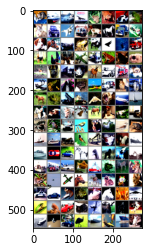

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(128)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
images, labels = images.to(device), labels.to(device)
outputs = model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer truck truck   dog


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))